In [1]:
import jieba
import unicodedata
import re
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu

In [2]:
path_cn = '../Resource/archive_/chinese.zh'
path_en = '../Resource/archive_/english.en'

In [3]:
def load_data(path):
    with open(path, encoding="utf-8") as f:
        data = pd.Series(f.readlines())
        data = data.str.replace('\n', ' ')
    
    return data

In [4]:
df_cn = load_data(path_cn)
df_en = load_data(path_en)


In [5]:
data_num = 5000

df_cn_train = df_cn[: data_num]
df_en_train = df_en[: data_num]

In [6]:
df_en_train

0                                          1929 or 1989? 
1       PARIS – As the economic crisis deepens and wid...
2       At the start of the crisis, many people likene...
3       Today, the mood is much grimmer, with referenc...
4       The tendency is either excessive restraint (Eu...
                              ...                        
4995    But now France is becoming a country dominated...
4996    If France wants to capitalize on the positive ...
4997    What Bastille Day revealed, even briefly and s...
4998    But doing so requires more than shallow promis...
4999                               A Kick-Off for Peace? 
Length: 5000, dtype: object

In [7]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )


def normalize_string(s):
    s = unicode_to_ascii(s)
    s = re.sub(r'([!.?])', r' \1', s)
    s = re.sub(r'[^a-zA-Z.!?]+', r' ', s)
    s = re.sub(r'\s+', r' ', s)
    return s


In [8]:
df_cn_train = df_cn_train.apply(lambda x: ' '.join(jieba.cut(x)))
df_en_train = df_en_train.apply(lambda x: ' '.join(jieba.cut(x)))


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.cache
Loading model cost 0.597 seconds.
Prefix dict has been built successfully.


In [9]:
'''
    Use the Tokenizer to transform the word into number 
    num_words is None means that all words will be contain
    Example:
    If have a sentence is "I love my dog"
    After "fit_on_texts" is {'I': 1, 'love': 2, 'my': 3, 'dog': 4}
    From the mentioned example:
    After "texts_to_sequences", the sentence becames [1, 2, 3, 4]
    "pad_sequences" is used to let all sentences as the same list size.
'''
tokenizer_cn = Tokenizer(num_words=None, char_level=False, filters='')
tokenizer_en = Tokenizer(num_words=None, char_level=False, filters='')

df_cn_train = df_cn_train.to_list()
df_en_train = df_en_train.to_list()

df_cn_train = [unicode_to_ascii(data) for data in df_cn_train]
df_en_train_in = ['<start> ' + unicode_to_ascii(data) for data in df_en_train]
df_en_train_out = [unicode_to_ascii(data) + '<end> ' for data in df_en_train]

tokenizer_cn.fit_on_texts(df_cn_train)

tokenizer_en.fit_on_texts(df_en_train_in)
tokenizer_en.fit_on_texts(df_en_train_out)


cn mean:  26.554
cn std:  12.505626093882706
cn max:  87
en mean:  71.7696
en std:  34.71163660561109
en max:  243


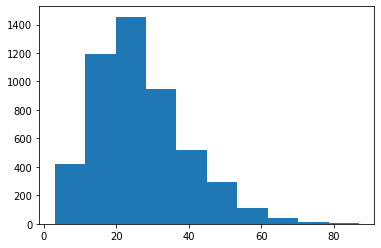

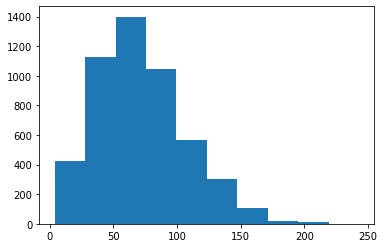

In [10]:
cn_len = [len(x.split(' ')) for x in df_cn_train]
en_len = [len(x.split(' ')) for x in df_en_train_in]

plt.figure()
plt.hist(cn_len)

plt.figure()
plt.hist(en_len)

print("cn mean: ", np.mean(cn_len))
print("cn std: ", np.std(cn_len))
print("cn max: ", np.max(cn_len))

print("en mean: ", np.mean(en_len))
print("en std: ", np.std(en_len))
print("en max: ", np.max(en_len))

In [11]:
batch_size = 64
max_sequence_length = 75
embedding_dim = 256
vocab_size_cn = len(tokenizer_cn.word_index)+1
vocab_size_en = len(tokenizer_en.word_index)+1
hidden_size = 512
attention_func = 'concat'
num_epochs = 200
mode = 'train'

In [12]:
cn_vector = tokenizer_cn.texts_to_sequences(df_cn_train)
en_vector_in = tokenizer_en.texts_to_sequences(df_en_train_in)
en_vector_out = tokenizer_en.texts_to_sequences(df_en_train_out)

cn_vector = pad_sequences(cn_vector, padding='post')
en_vector_in = pad_sequences(en_vector_in, padding='post')
en_vector_out = pad_sequences(en_vector_out, padding='post')

tmp = 0
for t in en_vector_in:
    tmp = max(tmp, max(t))

print(df_en_train_in[: 2])
print(en_vector_in[: 2])
tmp

['<start> 1929   or   1989 ?  ', '<start> PARIS   –   As   the   economic   crisis   deepens   and   widens ,   the   world   has   been   searching   for   historical   analogies   to   help   us   understand   what   has   been   happening .  ']
[[   8 4474   48 1184  141    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   8  916   18   17    2   54   91 4475    6 6190    1    2   40   29
    61 2525   16 1021 6191    4  179   46 1185   94   29   61 1958    3
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0

11060

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((cn_vector, en_vector_in, en_vector_out))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(128)
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [14]:
class Encoder(keras.Model):

    def __init__(self, batch_size=batch_size, max_sequence_length=max_sequence_length, embedding_dim=embedding_dim, vocab_size=vocab_size_cn, hidden_size=hidden_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.max_sequence_length = max_sequence_length
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.embedding = keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)
        self.lstm_1 = keras.layers.LSTM(units=hidden_size, return_sequences=True)
        self.lstm_2 = keras.layers.LSTM(units=hidden_size, return_sequences=True, return_state=True)

    def initial_hidden_state(self, batch_size):
        return (tf.zeros(shape=(batch_size, self.hidden_size)),
                tf.zeros(shape=(batch_size, self.hidden_size)))

    def call(self, x, initial_state,  training=False):
        x = self.embedding(x)
        x = self.lstm_1(x, initial_state=initial_state)
        x, state_h, state_c = self.lstm_2(x)
        return x, state_h, state_c


class Attention(keras.Model):
    def __init__(self, attention_func, hidden_size=256):
        super(Attention, self).__init__()
        self.attention_func = attention_func
        self.hidden_size = hidden_size

        if attention_func not in ['dot', 'general', 'concat']:
            raise ValueError("Unknown function, please check the input and make sure it's one of 'dot', 'general', 'concat'")

        if attention_func == 'general':

            self.wa = keras.layers.Dense(units=self.hidden_size)

        elif attention_func == 'concat':
            self.wa = keras.layers.Dense(units=self.hidden_size)
            self.va = keras.layers.Dense(1)

    def call(self, decoder_output, encoder_output, training=False):
        if self.attention_func == 'dot':
            score = tf.matmul(decoder_output, encoder_output, transpose_b=True)

        elif self.attention_func == 'general':
            score = tf.matmul(decoder_output, self.wa(encoder_output), transpose_b=True)

        elif self.attention_func == 'concat':
            decoder_output = tf.tile(decoder_output, [1, encoder_output.shape[1], 1])

            score = self.va(self.wa(tf.concat((decoder_output, encoder_output), axis=-1)))
            score = tf.transpose(score, [0, 2, 1])

        alignment = tf.nn.softmax(score, axis=2)
        context = tf.matmul(alignment, encoder_output)

        return context, alignment

class Decoder(keras.Model):
    def __init__(self, attention_func, batch_size=batch_size, max_sequence_length=max_sequence_length, embedding_dim=embedding_dim, vocab_size=vocab_size_en, hidden_size=hidden_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.attention = Attention(attention_func=attention_func)
        self.max_sequence_length = max_sequence_length
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.embedding = keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)
        self.lstm_1 = keras.layers.LSTM(units=hidden_size, return_sequences=True, return_state=True)
        self.wc = tf.keras.layers.Dense(hidden_size, activation='tanh')
        self.ws = tf.keras.layers.Dense(vocab_size)


    def call(self, sequence, state, encoder_output, training=False):

        embed = self.embedding(sequence)

        lstm_out, state_h, state_c = self.lstm_1(embed, initial_state=state)

        context, alignment = self.attention(lstm_out, encoder_output)

        lstm_out = tf.concat([tf.squeeze(context, 1), tf.squeeze(lstm_out, 1)], 1)
        lstm_out = self.wc(lstm_out)
        logits = self.ws(lstm_out)

        return logits, state_h, state_c, alignment

In [15]:
decoder = Decoder(attention_func=attention_func)
encoder = Encoder()

# Debugger
# initial_state = encoder.initial_hidden_state(1)
# encoder_outputs = encoder(tf.constant([[1]]), initial_state)
# decoder_outputs = decoder(tf.constant([[1]]), encoder_outputs[1:], encoder_outputs[0])

In [16]:
def loss_function(y_true, y_pred):
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    loss = loss_object(y_true, y_pred, sample_weight=mask)
    return loss

optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)
train_accuracy = tf.metrics.SparseCategoricalAccuracy()

@tf.function()
def training_step(cn, en_in, en_out, initial_states):
    loss = 0
    with tf.GradientTape() as Tape:
        en_outputs = encoder(cn, initial_states)
        en_states = en_outputs[1: ]
        de_state_h, de_state_c = en_states

        for i in range(en_out.shape[1]):
            decoder_in = tf.expand_dims(en_in[:, i], 1)
            logit, de_state_h, de_state_c, _ = decoder(decoder_in, (de_state_h, de_state_c), en_outputs[0])

            loss += loss_function(en_out[:, i], logit)

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = Tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss / en_out.shape[1]


In [17]:
if not os.path.exists('./checkpoints_luong/encoder'):
    os.makedirs('./checkpoints_luong/encoder')
if not os.path.exists('./checkpoints_luong/decoder'):
    os.makedirs('./checkpoints_luong/decoder')

# Uncomment these lines for inference mode
# encoder_checkpoint = tf.train.latest_checkpoint('./checkpoints_luong/encoder')
# decoder_checkpoint = tf.train.latest_checkpoint('./checkpoints_luong/decoder')

# if encoder_checkpoint is not None and decoder_checkpoint is not None:
#     encoder.load_weights(encoder_checkpoint)
#     decoder.load_weights(decoder_checkpoint)

In [18]:
def predict(test_source_text=None):
    if test_source_text is None:
        test_source_text = df_cn_train[np.random.choice(len(df_cn_train))]
    print(test_source_text)
    test_source_seq = tokenizer_cn.texts_to_sequences([test_source_text])
    print(test_source_seq)

    en_initial_states = encoder.initial_hidden_state(1)
    en_outputs = encoder(tf.constant(test_source_seq), en_initial_states)


    de_input = tf.constant([[tokenizer_en.word_index['<start>']]])
    de_state_h, de_state_c = en_outputs[1:]
    out_words = []
    alignments = []

    while True:
        de_output, de_state_h, de_state_c, alignment = decoder(
            de_input, (de_state_h, de_state_c), en_outputs[0])
        de_input = tf.expand_dims(tf.argmax(de_output, -1), 0)
        out_words.append(tokenizer_en.index_word[de_input.numpy()[0][0]])

        alignments.append(alignment.numpy())

        if out_words[-1] == '<end>' or len(out_words) >= 20:
            break

    print(' '.join(out_words))
    return np.array(alignments), test_source_text.split(' '), out_words

In [19]:
ep_loss = []
if mode == 'train':
    num_steps = data_num / batch_size

    # progbar = tf.keras.utils.Progbar(target=num_steps, stateful_metrics=['curr_loss', 'curr_accuracy'], unit_name='batch')
    for e in range(num_epochs):
        print(f'Epoch {e+1}/{num_epochs}')
        en_initial_state = encoder.initial_hidden_state(batch_size)
        encoder.save_weights(
            'checkpoints_luong/encoder/encoder_{}.h5'.format(e + 1))
        decoder.save_weights(
            'checkpoints_luong/decoder/decoder_{}.h5'.format(e + 1))
        for batch, (cn, en_in, en_out) in enumerate(train_dataset.take(-1)):
            loss = training_step(cn, en_in, en_out, en_initial_state)
            ep_loss.append(loss)
            # progbar.update(batch + 1, values=[('curr_loss', loss), ('curr_accuracy', acc)] )
            if batch % batch_size == 0:
                print('Epoch {} Batch {} Loss {:.4f} \n'.format(
                    e + 1, batch, loss.numpy()))

        predict()


Epoch 1/200
Epoch 1 Batch 0 Loss 2.6749 

Epoch 1 Batch 64 Loss 2.2496 

因此 领导权 已经 转移 到 发展中国家 的 妇女 手中 。  
[[86, 5901, 47, 883, 48, 384, 1, 382, 1329, 3]]
the the the the the the the the the the the the the the the the the the the the
Epoch 2/200
Epoch 2 Batch 0 Loss 2.0979 

Epoch 2 Batch 64 Loss 2.1166 

而 虽然 重大事件 往往 有 其 不 可预测性 ， 但 周年纪念 却 还是 有迹可循 的 。  
[[15, 416, 3338, 600, 31, 44, 29, 3242, 2, 14, 2625, 123, 232, 9202, 1, 3]]
the the the the the the , the <end>
Epoch 3/200
Epoch 3 Batch 0 Loss 2.0364 

Epoch 3 Batch 64 Loss 2.3540 

然而 ， 在 克什米尔 问题 上 ， 现在 由 代理人 和 恐怖分子 集团 参与 的 不 对称 冲突 可能 不会 退化 为 一场 全面 的 战争 ， 恰恰 是 由于 印度 和 巴基斯坦 都 拥有 相互 的 核威慑 。   的确 ， 这种 通过 代理人 进行 的 不 对称 冲突 已 成为 各个 国家 避免 付出 全面战争 代价 的 新 的 常规 方式 。  
[[680, 2, 4, 3594, 32, 41, 2, 114, 132, 2809, 5, 879, 1394, 628, 1, 29, 2099, 391, 39, 206, 4235, 33, 361, 1020, 1, 192, 2, 2126, 6, 338, 356, 5, 918, 25, 184, 1886, 1, 5531, 3, 1073, 2, 171, 82, 2809, 143, 1, 29, 2099, 391, 362, 111, 2024, 11, 795, 1456, 9485, 1100, 1, 62, 1, 1

（ 如果 TTIP 向 其他 经济体 开放 — — 比如 土耳其 、 墨西哥 和 加拿大 — — 则 收益 还 将 更 大 。   ）  
[[20, 67, 865, 151, 71, 377, 1038, 7, 7, 195, 412, 9, 1044, 5, 1971, 7, 7, 130, 1232, 83, 12, 36, 185, 3, 22]]
moreover , the aiib ’ s “ supercommittee , ” to hollande , the united states was categorized as a
Epoch 29/200
Epoch 29 Batch 0 Loss 0.8586 

Epoch 29 Batch 64 Loss 1.0023 

柏林 共识 ?  
[[1450, 672, 3443]]
the united kingdom ’ s puppet regimes have been heard to ions electrical only in the coming years . <end>
Epoch 30/200
Epoch 30 Batch 0 Loss 0.9295 

Epoch 30 Batch 64 Loss 0.9203 

想一想 小泉 20 世纪 80 年代 的 前辈 中曾根康弘 首相 吧 。  
[[12486, 852, 286, 290, 1564, 466, 1, 12487, 1949, 843, 1839, 3]]
the eiffel tower imbued the scourges of the 39th ploy to pray in quieter , to the us . <end>
Epoch 31/200
Epoch 31 Batch 0 Loss 0.8831 

Epoch 31 Batch 64 Loss 0.9509 

在 非洲之角 ， 没有 人能 像 他 那样 能够 确保 该 地区 继续 的 稳定 而 强硬 的 治理 。  
[[4, 6151, 2, 60, 10862, 278, 52, 411, 141, 352, 131, 102, 263, 1, 353, 15, 1851, 1, 629, 3]]
in the uni

Epoch 52 Batch 0 Loss 0.4540 

Epoch 52 Batch 64 Loss 0.4528 

非洲大陆 的 经济 增长 有所 放缓 ， 但 却 并 没有 陷入 大规模 的 经济衰退 。  
[[1297, 1, 19, 49, 627, 1323, 2, 14, 123, 30, 60, 707, 543, 1, 1477, 3]]
the continent ’ s economic opening suffers for the arab arab states . <end>
Epoch 53/200
Epoch 53 Batch 0 Loss 0.4188 

Epoch 53 Batch 64 Loss 0.4585 

美国 当选 总统 唐纳德 · 特朗普 准备 缓和 对 俄 关系 或许 有利于 安倍 继续 讨好 普京 ；   但 如果 俄罗斯 得到 了 美国 ， 就 再也 不 需要 日本 了 。  
[[21, 2045, 127, 1986, 70, 995, 579, 2605, 13, 1314, 368, 425, 1650, 469, 263, 3657, 429, 91, 14, 67, 265, 198, 8, 21, 2, 34, 1535, 29, 59, 88, 8, 3]]
president barack obama ’ s plan to act as its lives in the us . <end>
Epoch 54/200
Epoch 54 Batch 0 Loss 0.4552 

Epoch 54 Batch 64 Loss 0.4891 

想想 当今世界 的 其中 一个 奇迹 — — 个人电脑 。  
[[9606, 3797, 1, 294, 26, 5803, 7, 7, 5807, 3]]
consider the necessary - based hypertension improvement project in ghana members of achieving an 80% of millions of people .
Epoch 55/200
Epoch 55 Batch 0 Loss 0.3894 

Epoch 55 Batch 64 Loss 0.

Epoch 76 Batch 0 Loss 0.0735 

Epoch 76 Batch 64 Loss 0.0731 

自从 伦敦 讲话 之后 ， 卡尔 扎伊 积极 反对 反腐 行动 ， 把 军阀 引入 内阁 中 ， 无法 推动 公民 社会 的 建设 ， 反对 增加 妇女 在 议会 中 比例 的 活动 。  
[[3766, 812, 1134, 421, 2, 1088, 1489, 644, 339, 3174, 211, 2, 117, 9644, 1097, 2195, 27, 2, 146, 498, 619, 75, 1, 442, 2, 339, 133, 382, 4, 1183, 27, 952, 1, 307, 3]]
since his london speech , karzai ’ s daughter is the details of his daughter in 33 but japan after
Epoch 77/200
Epoch 77 Batch 0 Loss 0.0735 

Epoch 77 Batch 64 Loss 0.0663 

让 我们 从 欧元 为何 必须 下跌 开始 。  
[[66, 24, 61, 238, 1161, 50, 1480, 107, 3]]
the revolution that must be a top priority . <end>
Epoch 78/200
Epoch 78 Batch 0 Loss 0.0676 

Epoch 78 Batch 64 Loss 0.0515 

过去 几年 中 ， 受到 研发 推动 ， 越发 清洁 、 更为 高效 的 煤电 厂 建成 ， 而且 ， 特别 是 在 发达国家 中旧 技术 正在 淘汰 。  
[[162, 772, 27, 2, 229, 1265, 498, 2, 2385, 1594, 9, 343, 972, 1, 3297, 4376, 6146, 2, 136, 2, 216, 6, 4, 275, 10970, 197, 105, 5987, 3]]
fueled by the united nations summit on china and iran , achieved by the global econ

fortunately , we already have the know - how , resources , and , crucially , the political momentum to
Epoch 101/200
Epoch 101 Batch 0 Loss 0.0070 

Epoch 101 Batch 64 Loss 0.0090 

同时 也 需要 提升 消费税 来 维持 这 两支 箭 的 顺利 飞行 ， 但 不幸 的 是 ， 此次 提升 的 幅度 过大 ， 反而 对 这两项 政策 造成 了 阻碍 。  
[[153, 10, 59, 548, 3633, 58, 437, 17, 4671, 2030, 1, 3634, 3635, 2, 14, 1099, 1, 6, 2, 2268, 548, 1, 2575, 4672, 2, 1693, 13, 6868, 69, 186, 8, 1192, 3]]
the consumption - tax hike was needed to sustain them in flight . unfortunately , the hike was too large
Epoch 102/200
Epoch 102 Batch 0 Loss 0.0085 

Epoch 102 Batch 64 Loss 0.0069 

        国际 社会 各国 共同努力 实现 共同 事业 这一 前景 的确 令人激动 。  
[[42, 42, 42, 85, 75, 230, 6105, 92, 264, 2149, 73, 833, 1073, 11393, 3]]
the trillions of dollars that have been mobilized to address current woes , together with the trillions of investors ’
Epoch 103/200
Epoch 103 Batch 0 Loss 0.0084 

Epoch 103 Batch 64 Loss 0.0098 

更为重要 的 是 ， 不仅仅 是 德国 足球队 ， 而且 是 整个 国家 都 在 以 一个 年轻 、 帅气 、 悠闲 以及 无忧无虑 形象 

Epoch 121 Batch 0 Loss 0.0511 

Epoch 121 Batch 64 Loss 0.0772 

后来 我 再 一次 经历 了 这 一 转变 。  
[[1890, 96, 444, 577, 539, 8, 17, 152, 1451, 3]]
then it happened to me again . <end>
Epoch 122/200
Epoch 122 Batch 0 Loss 0.0448 

Epoch 122 Batch 64 Loss 0.0383 

这 一点 随着 新兴 发展 伙伴 — — 特别 是 金砖 国家 （ 巴西 、 俄罗斯 、 印度 、 中国 和 南非 ） — — 提供 结合 了 投资 和 非金融 援助 的 新 形式 的 援助 方案 而 显得 特别 重要 。  
[[17, 380, 282, 542, 80, 1241, 7, 7, 216, 6, 8238, 11, 20, 1188, 9, 265, 9, 356, 9, 68, 5, 1085, 22, 7, 7, 122, 2036, 8, 98, 5, 5305, 166, 1, 62, 896, 1, 166, 389, 15, 4007, 216, 103, 3]]
this is particularly relevant as emerging development partners , especially the brics ( brazil , russia , india , china
Epoch 123/200
Epoch 123 Batch 0 Loss 0.0334 

Epoch 123 Batch 64 Loss 0.0187 

拉丁美洲 和 东亚 的 发展中国家 正在 成长 ， 尽 � � 越来越 依赖 货币 中心 银行 的 外币 贷款 续命 。  
[[2925, 5, 6303, 1, 384, 105, 3221, 2, 4280, 84, 84, 317, 1115, 427, 785, 179, 1, 11809, 433, 11810, 3]]
developing countries in latin america and east asia were growing , although

Epoch 144 Batch 0 Loss 0.0006 

Epoch 144 Batch 64 Loss 0.0007 

与此同时 ， 法国 经历 了 相对 德国 来说 在 经济 问题 上 权力 的 损失 ， 它 仍 在 外交政策 上 发挥 决定性 的 作用 。  
[[372, 2, 182, 539, 8, 578, 158, 259, 4, 19, 32, 41, 554, 1, 589, 2, 78, 189, 4, 982, 41, 1087, 1561, 1, 336, 3]]
meanwhile , as france experiences a loss of power relative to germany on economic issues , it continues to play
Epoch 145/200
Epoch 145 Batch 0 Loss 0.0006 

Epoch 145 Batch 64 Loss 0.0006 

而 欧洲 的 情况 则 恰恰相反 ， 提升 一个 人 的 社会 地位 一向 是 相当 困难 的 ；   而且 在 经济 停滞 和 失业率 惊人 高企 的 情况 下 ， 提升 社会 地位 的 难度 更是 可想而知 。  
[[15, 28, 1, 145, 130, 2799, 2, 548, 26, 56, 1, 75, 428, 5102, 6, 871, 747, 1, 91, 136, 4, 19, 1043, 5, 551, 2366, 2511, 1, 145, 87, 2, 548, 75, 428, 1, 5480, 1760, 8649, 3]]
in europe , by contrast , improving one ’ s social standing has always been very difficult ; and ,
Epoch 146/200
Epoch 146 Batch 0 Loss 0.0006 

Epoch 146 Batch 64 Loss 0.0007 

在 非洲 国家 ， 无论 由衷 与否 ， 几乎 所有 政府 都 将 经济 现代化 奉 为 繁荣 的 基石 和 自身 执政 效率 的 衡量标准 而 推崇备至 。   许多 国家 夸耀 自身 

Epoch 167 Batch 0 Loss 0.0030 

Epoch 167 Batch 64 Loss 0.0023 

委员会 的 新 气候 经济 （ New   Climate   Economy ） 项目 集合 了 六 大洲 的 七大 领先 政策 研究 机构 ， 由前 政府首脑 、 财政部长 和 注明 商业 领袖 组成 的 专家 委员会 监督 ， 由 全球 著名 经济学家 组成 的 专家 委员会 担任 顾问 。  
[[326, 1, 62, 381, 19, 20, 3679, 2741, 4116, 22, 386, 4117, 8, 5496, 8673, 1, 8674, 3817, 69, 163, 213, 2, 5119, 4118, 9, 2259, 5, 8675, 1166, 943, 864, 1, 719, 326, 1719, 2, 132, 35, 1276, 804, 864, 1, 719, 326, 1900, 2670, 3]]
the commission ’ s new climate economy project brings together seven leading policy research institutes from six continents , overseen
Epoch 168/200
Epoch 168 Batch 0 Loss 0.0015 

Epoch 168 Batch 64 Loss 0.0014 

瑞典 和 联合国 艾滋病 规划署 将 携手 致力于 确保 国际 艾滋病 应对 措施 能够 继续 改变 — — 并 拯救 — — 生命 。  
[[1483, 5, 147, 301, 1637, 12, 2018, 993, 352, 85, 301, 305, 277, 141, 263, 369, 7, 7, 30, 1049, 7, 7, 915, 3]]
sweden and unaids will work together to ensure that the international aids response continues to transform – and save –
Epoch 169/200
Epoch 169 Batch 0 Loss 

Epoch 190 Batch 0 Loss 0.0003 

Epoch 190 Batch 64 Loss 0.0003 

结果 ， 新 的 牧场 或 农田 马上 被 放弃 ， 没有 机会 再 退耕还林 ， 恢复 其 独特 的 生态系统 。  
[[214, 2, 62, 1, 3828, 128, 3829, 2079, 51, 755, 2, 60, 246, 444, 7555, 2, 703, 44, 2352, 1, 3125, 3]]
as a result , the new pasture land or farmland is soon abandoned , with no prospect for regeneration of
Epoch 191/200
Epoch 191 Batch 0 Loss 0.0003 

Epoch 191 Batch 64 Loss 0.0003 

在 没有 共产党 控制 的 情况 下 ， 这些 安全 官员 背叛 了 他们 的 企业伦理 ， 参与 交易 ， 并且 在 交易 不 顺利 的 时候 施加 力量 。  
[[4, 60, 2383, 479, 1, 145, 87, 2, 45, 199, 704, 3188, 8, 38, 1, 7918, 2, 628, 1040, 2, 191, 4, 1040, 29, 3634, 1, 272, 1998, 375, 3]]
in the absence of communist party control , these security officers betrayed their corporate ethic and engaged in horse -
Epoch 192/200
Epoch 192 Batch 0 Loss 0.0003 

Epoch 192 Batch 64 Loss 0.0003 

因此 我们 更加 需要 放开 胸怀 ， 不吝 同情 。  
[[86, 24, 212, 59, 6123, 10735, 2, 10736, 4213, 3]]
that is all the more reason to act out of compassion and with generosity . <end>
Epoch 

In [ ]:
# Uncomment these lines for inference mode
encoder_checkpoint = tf.train.latest_checkpoint('checkpoints_luong/encoder')
decoder_checkpoint = tf.train.latest_checkpoint('checkpoints_luong/decoder')

if encoder_checkpoint is not None and decoder_checkpoint is not None:
    encoder.load_weights(encoder_checkpoint)
    decoder.load_weights(decoder_checkpoint)

In [ ]:
test = df_cn[data_num: data_num]